# Ma 412 Project : Deepfake Recognition


# Data processing 

In [270]:
import os
import time
import glob
import joblib
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
from PIL import Image
from scipy import ndimage
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

1. Path of the features


In [ ]:
real_images_path = "C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\data_2\\real"  
ai_images_path = "C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\data_2\\fake"      

2. Loading the data


In [ ]:
#open the data 
def load_images_from_folder(folder):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.jpg')):  # assuming jpg format
        img = Image.open(filename).convert('RGB')
        images.append(np.array(img))
    return images
real_images = load_images_from_folder(real_images_path) # Load real images
ai_images = load_images_from_folder(ai_images_path)   # Load AI-generated images

3. extraction of the features


In [ ]:
# Feature extraction
import cv2


def extract_features(images):
    features = []
    for img in tqdm(images, desc="Extracting features"):  # tqdm for progress bar
        img_features = []
        # Color histograms
        for channel in range(3):  # R, G, B
            hist, _ = np.histogram(img[:, :, channel], bins=16, range=(0, 256))  # 16 bins
            img_features.extend(hist / hist.sum())  # Normalize histogram

        # Channel means and stds
        for channel in range(3):
            img_features.append(np.mean(img[:, :, channel]))  # Mean
            img_features.append(np.std(img[:, :, channel]))   # Std

        # Grayscale mean and std
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)   # Convert to grayscale
        img_features.append(np.mean(gray))   # Mean
        img_features.append(np.std(gray))    # Std

        # Edge density
        edges = ndimage.sobel(gray)    # Edge detection
        edge_density = np.sum(edges > 0) / edges.size    # Edge density
        img_features.append(edge_density)   # Append edge density

        # FFT features
        fft = np.fft.fft2(gray)    # FFT computation
        fft_shift = np.fft.fftshift(fft)    # Shift zero freq to center
        magnitude = np.log(np.abs(fft_shift) + 1)    # Magnitude spectrum

        img_features.append(np.mean(magnitude))             # moyenne des hautes fréquences
        img_features.append(np.var(magnitude))              # variance fréquentielle
        img_features.append(np.percentile(magnitude,95))    # pics haute fréquence

        # blur features
        blur = cv2.Laplacian(gray, cv2.CV_64F).var()   # Variance of Laplacian (blur measure)
        img_features.append(blur)

        features.append(img_features)
    return np.array(features)

real_features = extract_features(real_images)    # Extract features for real images
ai_features = extract_features(ai_images)     # Extract features for AI images
X = np.vstack((real_features, ai_features))     
y = np.array([0] * len(real_features) + [1] * len(ai_features))    

Extracting features: 100%|██████████| 96/96 [00:18<00:00,  5.14it/s]


4. Train-Test split


In [54]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

5. Standardization of the data


In [ ]:
scaler = StandardScaler()   # Feature scaling
X_train = scaler.fit_transform(X_train)    # Scale training data
X_test = scaler.transform(X_test)   # Scale test data

5. Dimensionality reduction


In [ ]:
pca = PCA(n_components=0.95, random_state=42)    # PCA to retain 95% variance
X_train = pca.fit_transform(X_train)    # Scale training data
X_test = pca.transform(X_test)    # Scale test data

# Model training 

1. Random Forest Classifier


In [ ]:
param_grid = {
    "n_estimators": [50, 100, 150, 200, 250],
    "max_depth": [2,4,5, 8, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [ 2, 4, 6, 8],
    "max_features": ["sqrt", "log2"]
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)   # Base Random Forest model

grid_search = GridSearchCV(   # Grid Search for hyperparameter tuning
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,                    # 5-fold cross validation
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)   # Fit Grid Search

best_rf = grid_search.best_estimator_   # Best Random Forest model
print("Meilleurs paramètres trouvés :")
print(grid_search.best_params_)

rf = best_rf

start_time = time.time()
best_rf.fit(X_train, y_train)   # Train the model
rf_train_time = time.time() - start_time
start_time = time.time()
y_pred_rf = best_rf.predict(X_test)   # Predict on test set
rf_pred_time = time.time() - start_time
rf_accuracy = accuracy_score(y_test, y_pred_rf)   # Accuracy calculation


Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Meilleurs paramètres trouvés :
{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 250}


2. MLP Classifier


MLP Classifier, parameters determination


In [ ]:
param_grid_mlp = {
    'hidden_layer_sizes': [(32,), (64,), (32,16), (64,32)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0005, 0.001, 0.005],
    'max_iter': [800,1500],
}

grid_mlp = GridSearchCV(   # Grid Search for MLP hyperparameter tuning
    estimator=MLPClassifier(activation='relu', solver='adam', early_stopping=True, random_state=42),
    param_grid=param_grid_mlp,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_mlp.fit(X_train, y_train)   # Fit Grid Search
mlp_clf = grid_mlp.best_estimator_   # Best MLP model

print("\nBest MLP parameters :", grid_mlp.best_params_)

MLP Classifier training


In [ ]:
# MLP Classifier
  
mlp_clf = MLPClassifier(alpha=0.01,hidden_layer_sizes=(64,32),learning_rate_init=0.005,max_iter=800,activation='relu', solver='adam', early_stopping=True)         
start_time = time.time()
mlp_clf.fit(X_train, y_train)   # Train MLP
mlp_train_time = time.time() - start_time
start_time = time.time()
y_pred_mlp = mlp_clf.predict(X_test)   # Predict with MLP
mlp_pred_time = time.time() - start_time
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)   # Accuracy calculation
print(f"accuracy = {mlp_accuracy}")


accuracy = 0.7692307692307693


3. SVM Classifier


SVM, parameters determination


In [ ]:
from sklearn.svm import SVC
param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001, 0.0001]
}
svm = SVC()
grid = GridSearchCV(   # Grid Search for SVM hyperparameter tuning
    estimator=svm,
    param_grid=param_grid,
    cv=5,                     
    scoring='accuracy',       
    n_jobs=-1,               
    verbose=2
)


grid.fit(X_train, y_train)   # train the grid search


print("Meilleurs paramètres trouvés :")
print(grid.best_params_)

print("\nMeilleure performance (cross-validation) :")
print(grid.best_score_)


best_model = grid.best_estimator_  # get the best model from grid search
test_accuracy = best_model.score(X_test, y_test)  # evaluate on test set

print("\nAccuracy sur le test set : ", test_accuracy)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Meilleurs paramètres trouvés :
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

Meilleure performance (cross-validation) :
0.7189247311827958

Accuracy sur le test set :  0.717948717948718


SVM training

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=2, gamma='scale', probability=True)  # Best SVM model

start_time = time.time()
svm.fit(X_train, y_train)  # Train the model
svm_train_time = time.time() - start_time

start_time = time.time()
y_pred_svm = svm.predict(X_test)  # Predict with SVM
svm_pred_time = time.time() - start_time

svm_accuracy = accuracy_score(y_test, y_pred_svm)   # Accuracy calculation

3. Saving the models


In [ ]:
# Save models
model_dir = Path("./models")
model_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(scaler, model_dir / "scaler.joblib")   
joblib.dump(pca, model_dir / "pca.joblib")
joblib.dump(best_rf, model_dir / "random_forest.joblib")
joblib.dump(mlp_clf, model_dir / "mlp.joblib")
joblib.dump(svm, model_dir / "svm.joblib")

['models\\svm.joblib']

4. Evaluation of the models


Confusion matrix for Random_Forest:
[[14  6]
 [ 7 12]]
Confusion matrix for MLP:
[[18  2]
 [ 7 12]]
Confusion matrix for SVM:
[[16  4]
 [ 7 12]]
Random Forest Accuracy: 0.6667, Training Time: 0.71s, Prediction Time: 0.09s
MLP Accuracy: 0.7692, Training Time: 0.11s, Prediction Time: 0.00s
SVM Accuracy: 0.7179, Training Time: 0.01s, Prediction Time: 0.00s


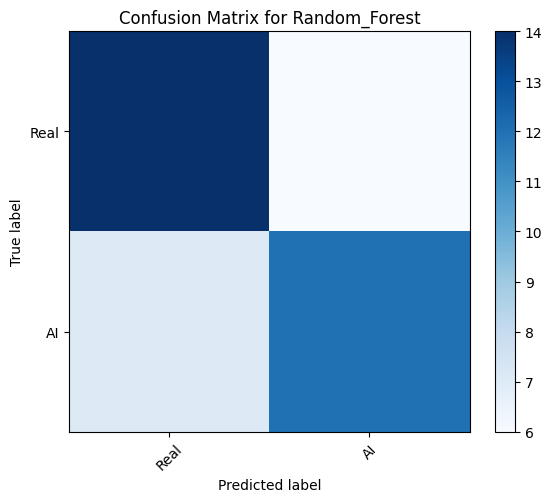

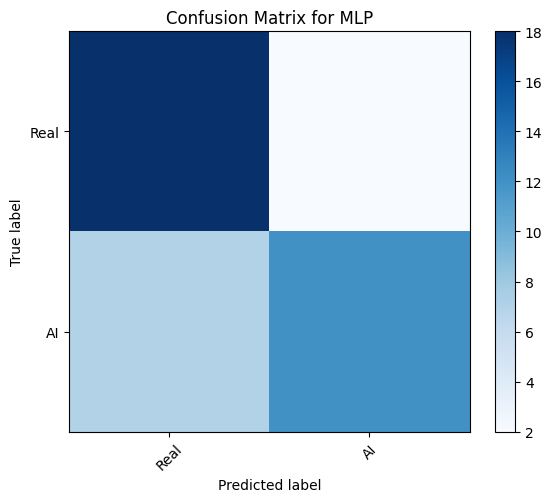

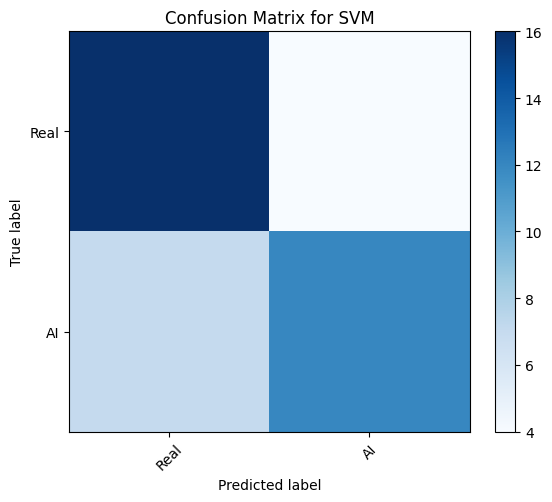

In [252]:
# Evaluation reports        
def save_evaluation_report(y_test, y_pred, model_name):
    report = classification_report(y_test, y_pred, target_names=['Real', 'AI'])
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion matrix for {model_name}:\n{cm}")
    with open(model_dir / f"{model_name}_report.txt", "w") as f:
        f.write(f"Classification Report for {model_name}:\n")
        f.write(report)
        f.write("\nConfusion Matrix:\n")
        f.write(np.array2string(cm))
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Real', 'AI'], rotation=45)
    plt.yticks(tick_marks, ['Real', 'AI'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(model_dir / f"{model_name}_confusion_matrix.png")
save_evaluation_report(y_test, y_pred_rf, "Random_Forest")
save_evaluation_report(y_test, y_pred_mlp, "MLP")
save_evaluation_report(y_test, y_pred_svm, "SVM")

# Print summary
print(f"Random Forest Accuracy: {rf_accuracy:.4f}, Training Time: {rf_train_time:.2f}s, Prediction Time: {rf_pred_time:.2f}s")
print(f"MLP Accuracy: {mlp_accuracy:.4f}, Training Time: {mlp_train_time:.2f}s, Prediction Time: {mlp_pred_time:.2f}s") 
print(f"SVM Accuracy: {svm_accuracy:.4f}, Training Time: {svm_train_time:.2f}s, Prediction Time: {svm_pred_time:.2f}s")

5. ROC curve


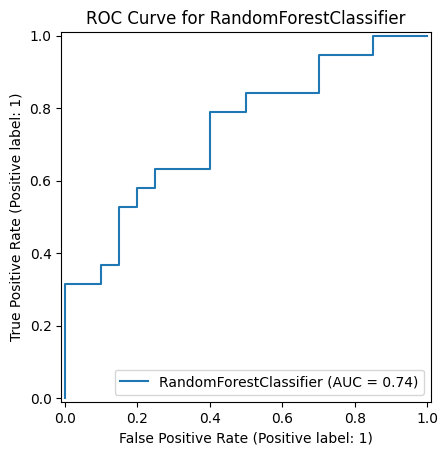

<Figure size 640x480 with 0 Axes>

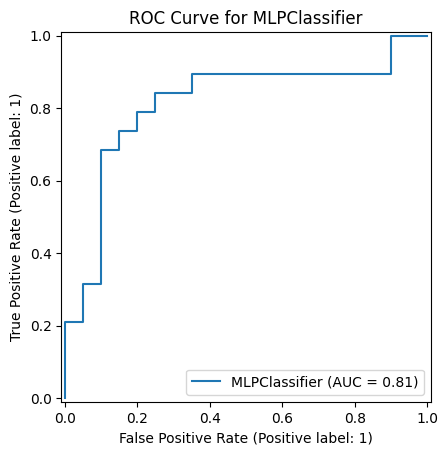

<Figure size 640x480 with 0 Axes>

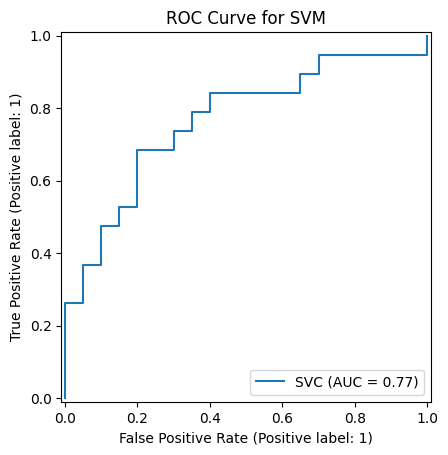

ROC AUC Score for RandomForestClassifier: 0.7395
ROC AUC Score for MLPClassifier: 0.8132
ROC AUC Score for SVM: 0.7658


<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, RocCurveDisplay

# Plot ROC curves
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)  # Plot ROC curve for Random Forest
plt.title('ROC Curve for RandomForestClassifier')
plt.show()
plt.savefig(model_dir/'roc_random_forest.png')

RocCurveDisplay.from_estimator(mlp_clf, X_test, y_test)
plt.title('ROC Curve for MLPClassifier')
plt.show()
plt.savefig(model_dir/'roc_mlp_classifier.png')

RocCurveDisplay.from_estimator(svm, X_test, y_test)
plt.title('ROC Curve for SVM')
plt.show()
plt.savefig(model_dir/'roc_svm.png')

# Calculate ROC AUC
y_test_proba = best_rf.predict_proba(X_test)[:, 1]   # Probabilities for positive class
roc_auc = roc_auc_score(y_test, y_test_proba)    # ROC AUC calculation
print(f"ROC AUC Score for RandomForestClassifier: {roc_auc:.4f}")

y_test_proba_mlp = mlp_clf.predict_proba(X_test)[:, 1]
roc_auc_mlp = roc_auc_score(y_test, y_test_proba_mlp)
print(f"ROC AUC Score for MLPClassifier: {roc_auc_mlp:.4f}")

y_test_proba_svm = svm.predict_proba(X_test)[:, 1]
roc_auc_svm = roc_auc_score(y_test, y_test_proba_svm)
print(f"ROC AUC Score for SVM: {roc_auc_svm:.4f}")

# testing of the model

### Data processing

In [ ]:
# ================================
# 🔍 Fonction pour tester une image
# ================================
import cv2
def extract_features_single_image(img):
    img_features = []

    # Histogrammes couleurs
    for channel in range(3):
        hist, _ = np.histogram(img[:, :, channel], bins=16, range=(0, 256))
        img_features.extend(hist / hist.sum())

    # Moyennes / écarts-types
    for channel in range(3):
        img_features.append(np.mean(img[:, :, channel]))
        img_features.append(np.std(img[:, :, channel]))

    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_features.append(np.mean(gray))
    img_features.append(np.std(gray))

    # Densité des contours
    edges = ndimage.sobel(gray)
    img_features.append(np.sum(edges > 0) / edges.size)

    # FFT features
    fft = np.fft.fft2(gray)
    fft_shift = np.fft.fftshift(fft)
    magnitude = np.log(np.abs(fft_shift) + 1)

    img_features.append(np.mean(magnitude))         
    img_features.append(np.var(magnitude))          
    img_features.append(np.percentile(magnitude,95))

    # blur features
    blur = cv2.Laplacian(gray, cv2.CV_64F).var()
    img_features.append(blur)

    return np.array(img_features).reshape(1, -1)


def predict_image(image_path, model="rf"):

    img = Image.open(image_path).convert("RGB")#load image
    img = np.array(img)

    features = extract_features_single_image(img)#extract features

    scaler = joblib.load("./models/scaler.joblib") #load scaler
    pca = joblib.load("./models/pca.joblib")  #load PCA

    features = scaler.transform(features)              # => (1,32)
    features = pca.transform(features)                 # => (1,24)
    

    # load the requested model
    if model == "rf":
        clf = joblib.load("./models/random_forest.joblib")
    elif model == "mlp":
        clf = joblib.load("./models/mlp.joblib")
    else:
        clf = joblib.load("./models/svm.joblib")

    # Prédiction
    pred = clf.predict(features)[0]
    proba = clf.predict_proba(features)[0][1]  # prob IA

    label = "AI generated" if pred == 1 else "Real image"
    print(f"\n===== Prediction Result for model = {model} =====")
    print(f"📄 Image : {image_path}")
    print(f"📌 Predicted Class : {label}")
    print(f"📊 AI Probability : {proba*100:.2f}%")

    return pred, proba


###  predictions

1. Real Eifel tour image

In [264]:
#display the image 
img = Image.open("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\tour-eiffel.jpg")
img.show()
# predict the image with both models
predict_image("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\tour-eiffel.jpg", model="rf")

predict_image("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\tour-eiffel.jpg", model="mlp")

predict_image("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\tour-eiffel.jpg", model="svm")


===== Prediction Result for model = rf =====
📄 Image : C:\Users\mathi\Desktop\outils_mathematiques_avances\Project\test_image\tour-eiffel.jpg
📌 Predicted Class : Real image
📊 AI Probability : 30.99%

===== Prediction Result for model = mlp =====
📄 Image : C:\Users\mathi\Desktop\outils_mathematiques_avances\Project\test_image\tour-eiffel.jpg
📌 Predicted Class : Real image
📊 AI Probability : 6.94%

===== Prediction Result for model = svm =====
📄 Image : C:\Users\mathi\Desktop\outils_mathematiques_avances\Project\test_image\tour-eiffel.jpg
📌 Predicted Class : Real image
📊 AI Probability : 35.22%


(0, 0.3522060208962788)

2. Real sea image

In [265]:
#display the image 
img = Image.open("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\photo_mer.jpg")
img.show()
# predict the image with both models
predict_image("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\photo_mer.jpg", model="rf")

predict_image("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\photo_mer.jpg", model="mlp")

predict_image("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\photo_mer.jpg", model="svm")


===== Prediction Result for model = rf =====
📄 Image : C:\Users\mathi\Desktop\outils_mathematiques_avances\Project\test_image\photo_mer.jpg
📌 Predicted Class : Real image
📊 AI Probability : 38.47%

===== Prediction Result for model = mlp =====
📄 Image : C:\Users\mathi\Desktop\outils_mathematiques_avances\Project\test_image\photo_mer.jpg
📌 Predicted Class : AI generated
📊 AI Probability : 57.94%

===== Prediction Result for model = svm =====
📄 Image : C:\Users\mathi\Desktop\outils_mathematiques_avances\Project\test_image\photo_mer.jpg
📌 Predicted Class : Real image
📊 AI Probability : 34.36%


(0, 0.3436288218238625)

3.Ai generated image

In [266]:
#display the image 
img = Image.open("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\ia_image_2.jpg")
img.show()
# predict the image with both models
predict_image("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\ia_image_2.jpg", model="rf")

predict_image("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\ia_image_2.jpg", model="mlp")

predict_image("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\ia_image_2.jpg", model="svm")


===== Prediction Result for model = rf =====
📄 Image : C:\Users\mathi\Desktop\outils_mathematiques_avances\Project\test_image\ia_image_2.jpg
📌 Predicted Class : AI generated
📊 AI Probability : 72.83%

===== Prediction Result for model = mlp =====
📄 Image : C:\Users\mathi\Desktop\outils_mathematiques_avances\Project\test_image\ia_image_2.jpg
📌 Predicted Class : AI generated
📊 AI Probability : 84.11%

===== Prediction Result for model = svm =====
📄 Image : C:\Users\mathi\Desktop\outils_mathematiques_avances\Project\test_image\ia_image_2.jpg
📌 Predicted Class : AI generated
📊 AI Probability : 71.56%


(1, 0.7155901984608364)

4. Ai generated image

In [267]:
#display the image 
img = Image.open("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\ia_image_1.jpg")
img.show()
# predict the image with both models
predict_image("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\ia_image_1.jpg", model="rf")

predict_image("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\ia_image_1.jpg", model="mlp")

predict_image("C:\\Users\\mathi\\Desktop\\outils_mathematiques_avances\\Project\\test_image\\ia_image_1.jpg", model="svm")


===== Prediction Result for model = rf =====
📄 Image : C:\Users\mathi\Desktop\outils_mathematiques_avances\Project\test_image\ia_image_1.jpg
📌 Predicted Class : AI generated
📊 AI Probability : 56.01%

===== Prediction Result for model = mlp =====
📄 Image : C:\Users\mathi\Desktop\outils_mathematiques_avances\Project\test_image\ia_image_1.jpg
📌 Predicted Class : AI generated
📊 AI Probability : 67.31%

===== Prediction Result for model = svm =====
📄 Image : C:\Users\mathi\Desktop\outils_mathematiques_avances\Project\test_image\ia_image_1.jpg
📌 Predicted Class : AI generated
📊 AI Probability : 57.24%


(1, 0.5724426986513135)

# Mixt

In [39]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=200,
    max_samples=0.8,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

bagging.fit(X_train, y_train)
y_pred_bag = bagging.predict(X_test)

print("Accuracy Bagging :", accuracy_score(y_test, y_pred_bag))


Accuracy Bagging : 0.6410256410256411
